In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [7]:
df = pd.read_csv('Data/Weekly.csv')
print(df.shape)
df.head()

(1089, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [6]:
df.tail()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up
1088,2010,1.034,0.283,1.281,2.969,-0.861,2.707105,0.069,Up


In [126]:
y = df.set_index("Year")["Direction"]
X = df.set_index("Year").drop(columns=["Direction", "Today"])
# X = df.drop(columns=["Direction" ])
y.replace({"Up": 1, "Down": 0}, inplace=True)

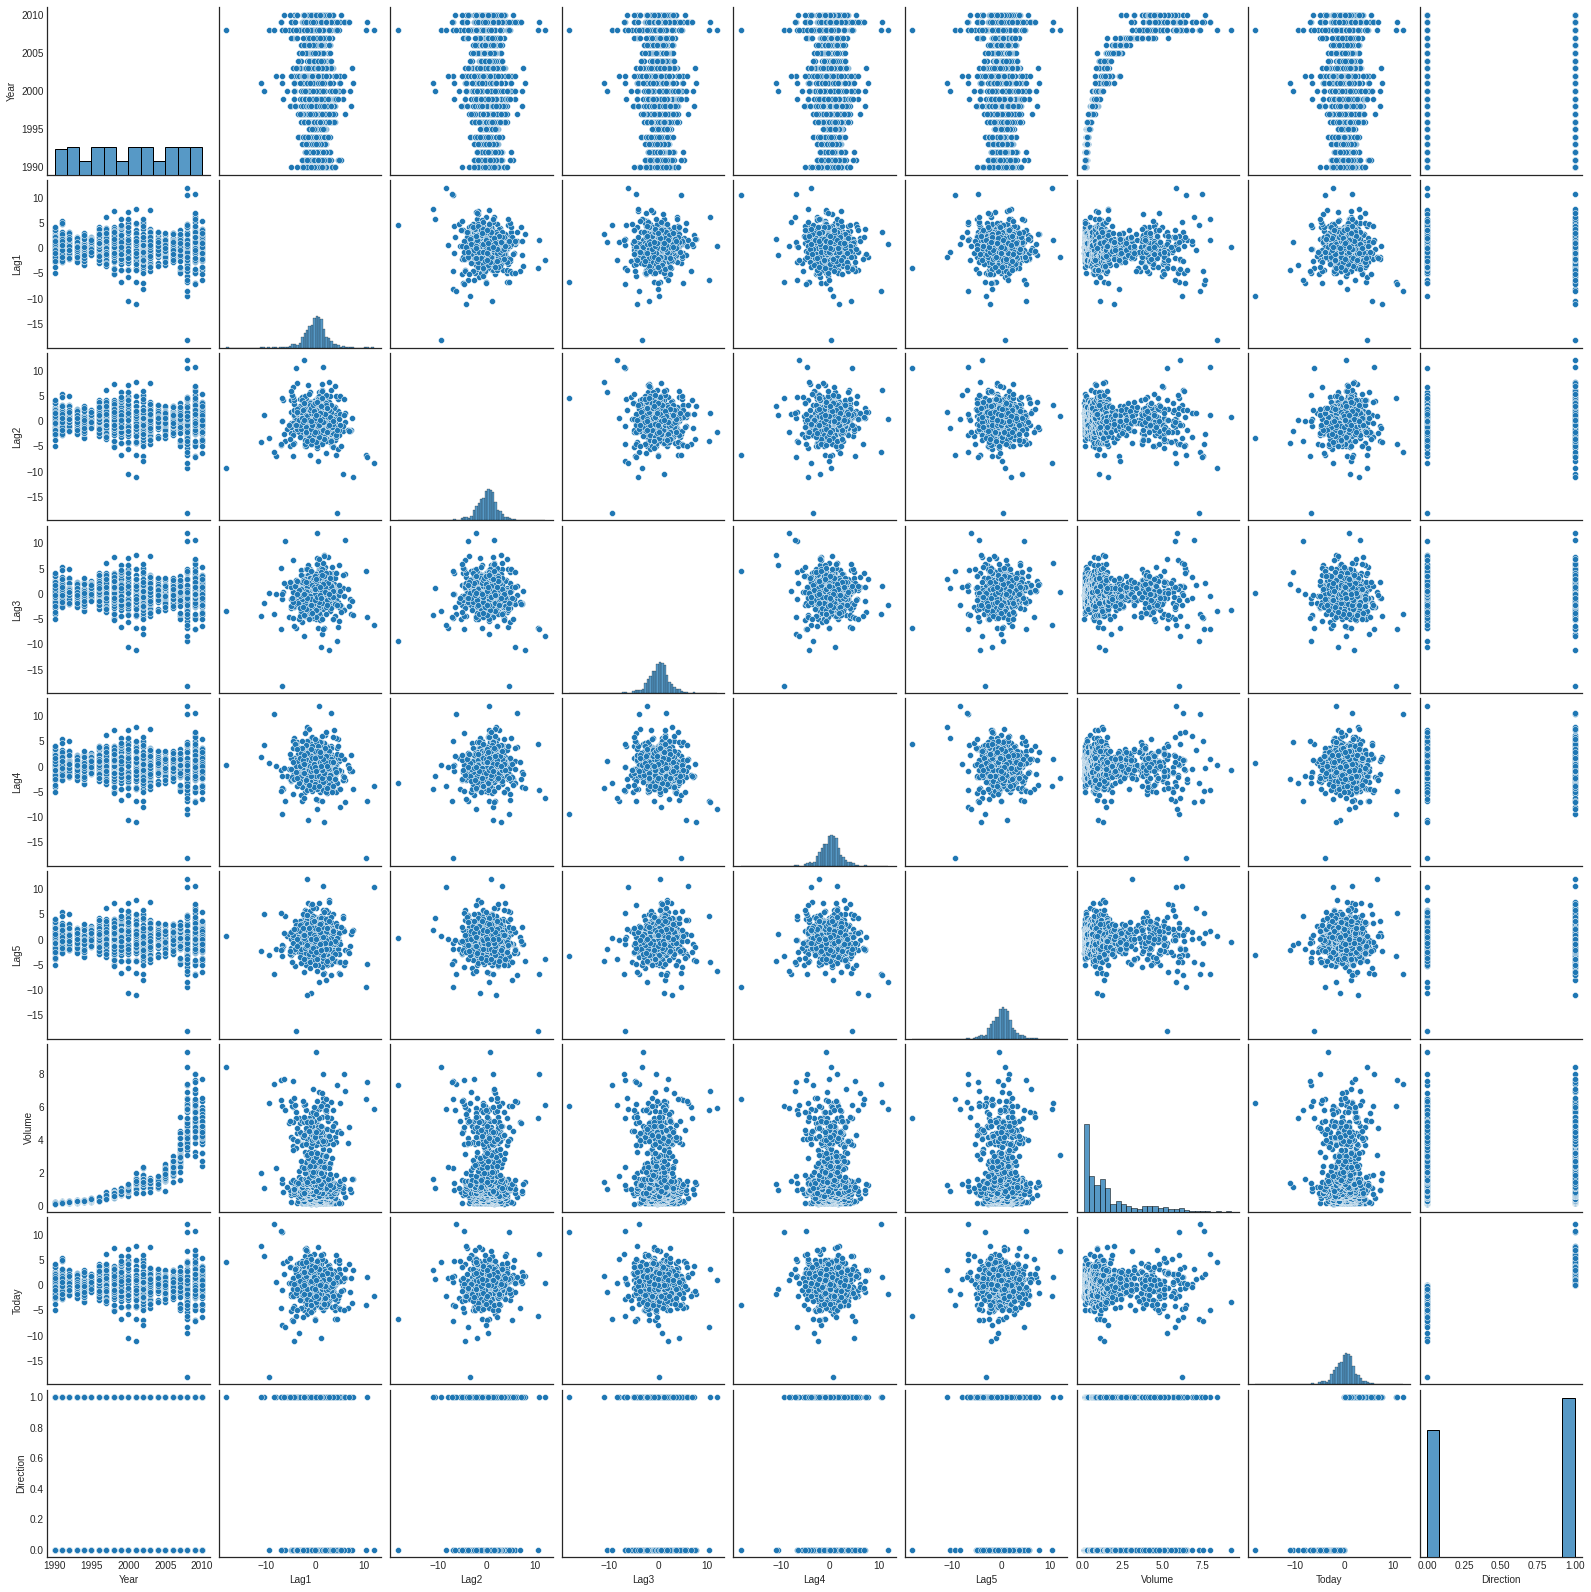

In [127]:
sns.pairplot(df)

It seems like the only nontrivial realtion here is that of `Volume` and `Year`. </br>
Let's justify this formally:

<AxesSubplot:>

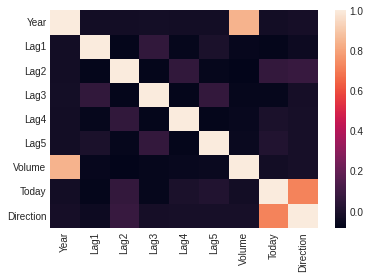

In [128]:
sns.heatmap(df.corr())

We see minor correlations (~0.2) between the lags. </br>
They are also related to `Today`, to some extent. </br>
Though the relationship between the `Volume` and `Year` is seen to be nonlinear in the previous figure, the correlation is nonetheless strong.

In [129]:
from statsmodels.tools.tools import add_constant
logit = sm.Logit(y, add_constant(X)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sat, 03 Sep 2022   Pseudo R-squ.:                0.006580
Time:                        18:38:03   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

`Lag2` has turned out to be statistically significant. </br>
The design isn't much collinear, so there doesn't seem to be a reason to doubt this result. </br>
Alternatively, we can explicitly fit the model only keeping the `Lag2` variable:

In [130]:
logit2 = sm.Logit(y, add_constant(X["Lag2"])).fit()
logit2.summary()

Optimization terminated successfully.
         Current function value: 0.684306
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1087
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Sep 2022   Pseudo R-squ.:                0.003866
Time:                        18:38:17   Log-Likelihood:                -745.21
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.01617
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2147      0.061      3.507      0.000       0.095       0.335
Lag2           0.0628      0.026      2.382      0.017       0.011       0.114
==============================================================================
"""

As expected, the result is essentially the same

In [131]:
from sklearn.linear_model import LogisticRegression
logit_sk = LogisticRegression()
logit_sk.fit(X, y)
logit_sk.coef_

array([[-0.04123854,  0.05840384, -0.01605138, -0.02776243, -0.01446302,
        -0.02270963]])

In [132]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def plot_cm(clf, X, y, title=""):
    f, axs = plt.subplots(1, 2, figsize=(10, 4))

    for ax, normalize in zip(axs, ["true", "pred"]):
        ConfusionMatrixDisplay.from_estimator(
            clf, X, y, 
            cmap=plt.cm.Blues, 
            normalize=normalize,
            ax=ax
        )
        ax.set_title("Normalized along: " + normalize)
    f.suptitle(title, fontsize=16)

              precision    recall  f1-score   support

           0       0.53      0.11      0.18       484
           1       0.56      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089



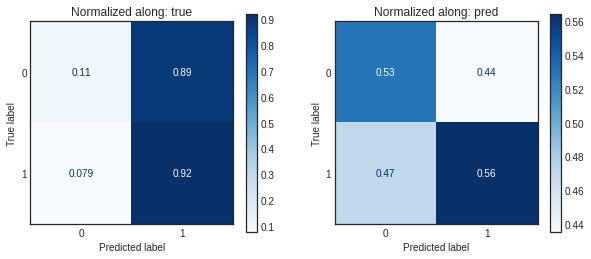

In [133]:
print(classification_report(y, logit_sk.predict(X)))
plot_cm(logit_sk, X, y)

 The classifier has failed to identify most of the "Down" trends -- 0-recall is very low: 0.11 </br>
 Apart from that, there seems to be a nontrivial trend captured by the classifier in identifying the "Up" trends: </br>
 $>0.5$ precision and almost perfect recall, resulting in relatilevy (domain-wise) high f1-score. </br>
 Is this indeed so?

In [134]:
X_train = X[:800]
y_train = y[:800]
X_test = X[800:]
y_test = y[800:]

              precision    recall  f1-score   support

           0       0.47      0.68      0.56       131
           1       0.58      0.37      0.45       158

    accuracy                           0.51       289
   macro avg       0.53      0.52      0.50       289
weighted avg       0.53      0.51      0.50       289



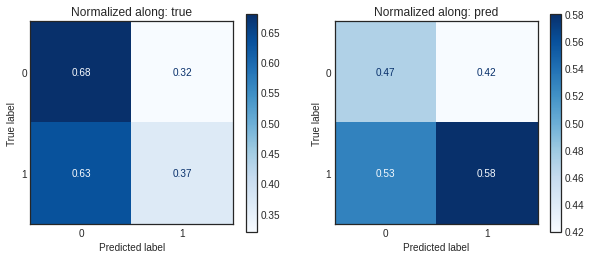

In [135]:
logit2 = LogisticRegression()
logit2.fit(X_train, y_train)
plot_cm(logit2, X_test, y_test)
print(classification_report(y_test, logit2.predict(X_test)))

Overall accuracy isn't impressive: a dummy 1-classifier achieves 0.55 (likewise accuracy) just because of the ratio of the labels in the test sample.


              precision    recall  f1-score   support

           0       1.00      0.00      0.00       131
           1       0.55      1.00      0.71       158

    accuracy                           0.55       289
   macro avg       0.77      0.50      0.35       289
weighted avg       0.75      0.55      0.39       289



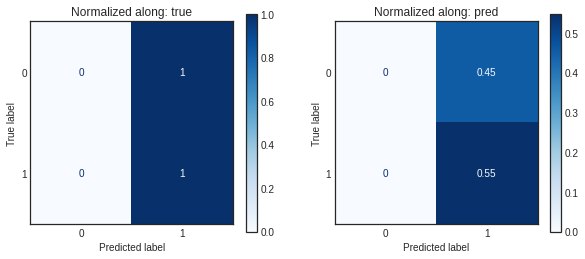

In [136]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
plot_cm(dummy, X_test, y_test)
print(
    classification_report(
        y_test, dummy.predict(X_test), 
        zero_division=True
    )
)

Performance of the estimator on the "Down" trends is not impressive. </br>
However, there seems to be a positive difference in the 1-precision compared with the dummy one. </br>
</br>
Though the classifier might not often identify the opportunity (recall-1 is low), when it does, this might suggest a buying strategy. </br> 
(since it seems to be slightly (3%) better than guessing)
</br></br>
Let's see what some other classifiers might tell us. </br></br>
Note: the most reasonable candidate for concrete Naive Bayes assumptions is `GaussianNB` since all of the predictors are more or less normal (see the pairplot) and quantitative.

In [187]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB

lda_clf, qda_clf, knn_clf, nb_clf = classifiers = [
    LDA().fit(X_train, y_train), 
    QDA().fit(X_train, y_train), 
    # crossvalidated the K param
    KNN(6).fit(X_train, y_train), 
    GaussianNB().fit(X_train, y_train)
]

LinearDiscriminantAnalysis 
               precision    recall  f1-score   support

           0       0.47      0.69      0.56       131
           1       0.58      0.35      0.44       158

    accuracy                           0.51       289
   macro avg       0.52      0.52      0.50       289
weighted avg       0.53      0.51      0.49       289

QuadraticDiscriminantAnalysis 
               precision    recall  f1-score   support

           0       0.35      0.05      0.08       131
           1       0.54      0.93      0.68       158

    accuracy                           0.53       289
   macro avg       0.45      0.49      0.38       289
weighted avg       0.46      0.53      0.41       289

KNeighborsClassifier 
               precision    recall  f1-score   support

           0       0.49      0.61      0.54       131
           1       0.60      0.47      0.53       158

    accuracy                           0.54       289
   macro avg       0.54      0.54      0.54 

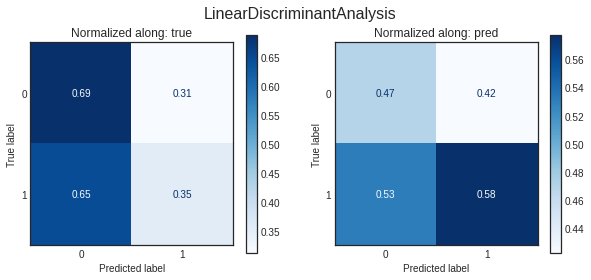

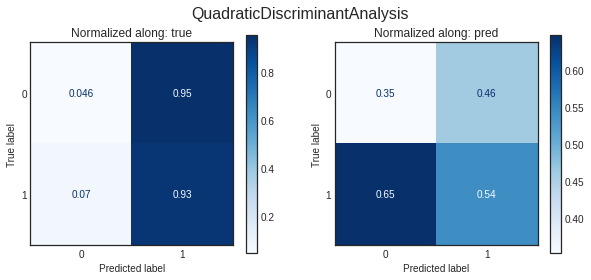

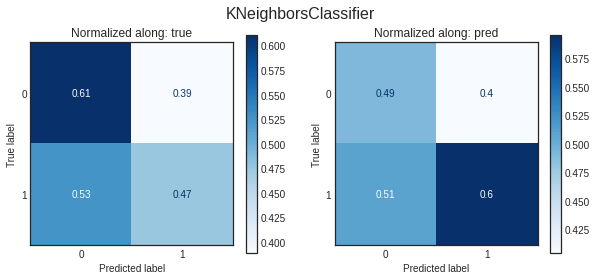

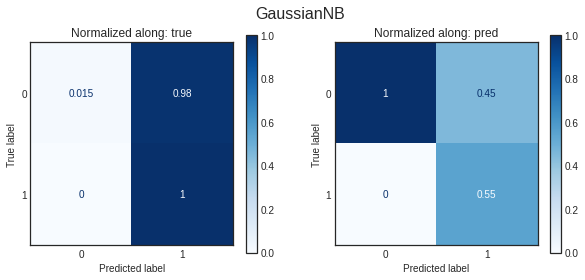

In [188]:
for clf in classifiers:
    plot_cm(clf, X_test, y_test, title=clf.__class__.__name__)
    print(
        clf.__class__.__name__,'\n', 
        classification_report(y_test, clf.predict(X_test))
    )

The two most interesting classifiers here are:
- `KNN(6)`, which has a higher 1-recall than logistic;
- `NB`, which has a nontrivial 0-precision (though a very small 0-recall), and can be potentially used for 0-trend detections.

## Experementation with the features

Let's know fit `PolynomialFeatures` to the train data and see whether this will affect the results

In [139]:
X_train

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
Year,,,,,,
1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976
1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574
1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837
1990,3.514,-2.576,-0.270,0.816,1.572,0.161630
1990,0.712,3.514,-2.576,-0.270,0.816,0.153728
...,...,...,...,...,...,...
2005,-1.477,1.253,0.411,0.831,-3.266,1.953106
2005,3.053,-1.477,1.253,0.411,0.831,1.883610
2005,0.799,3.053,-1.477,1.253,0.411,1.627978


In [150]:
from sklearn.preprocessing import PolynomialFeatures
pol_feat = PolynomialFeatures(include_bias=False).fit(
    X_train
)
X_train_pol = pd.DataFrame(
    pol_feat.transform(X_train), 
    columns=pol_feat.get_feature_names_out(X_train.columns),
    index=X_train.index
)
X_test_pol = pd.DataFrame(
    pol_feat.transform(X_test), 
    columns=pol_feat.get_feature_names_out(X_train.columns),
    index=X_test.index
)
X_train_pol.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Lag1^2,Lag1 Lag2,Lag1 Lag3,Lag1 Lag4,...,Lag3^2,Lag3 Lag4,Lag3 Lag5,Lag3 Volume,Lag4^2,Lag4 Lag5,Lag4 Volume,Lag5^2,Lag5 Volume,Volume^2
Year,,,,,,,,,,,,,,,,,,,,,
1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,0.665856,1.282752,-3.211776,-0.186864,...,15.492096,0.901344,13.713024,-0.609986,0.052441,0.797836,-0.035490,12.138256,-0.539936,0.024018
1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,0.072900,-0.220320,-0.424440,1.062720,...,2.471184,-6.187392,-0.359988,0.233558,15.492096,0.901344,-0.584787,0.052441,-0.034023,0.022074
1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,6.635776,0.695520,-2.102016,-4.049472,...,0.665856,1.282752,-3.211776,0.130427,2.471184,-6.187392,0.251265,15.492096,-0.629120,0.025548
1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,12.348196,-9.052064,-0.948780,2.867424,...,0.072900,-0.220320,-0.424440,-0.043640,0.665856,1.282752,0.131890,2.471184,0.254082,0.026124
1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,0.506944,2.501968,-1.834112,-0.192240,...,6.635776,0.695520,-2.102016,-0.396003,0.072900,-0.220320,-0.041507,0.665856,0.125442,0.023632


In [152]:
logit = sm.Logit(y_train, X_train_pol).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.673174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  800
Model:                          Logit   Df Residuals:                      773
Method:                           MLE   Df Model:                           26
Date:                Sat, 03 Sep 2022   Pseudo R-squ.:                 0.01902
Time:                        18:44:45   Log-Likelihood:                -538.54
converged:                       True   LL-Null:                       -548.98
Covariance Type:            nonrobust   LLR p-value:                    0.7478
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Lag1           -0.1316      0.075     -1.766      0.077      -0.278       0.014
Lag2            0.0575      0.076      0.753      0.452      -0.092       0.207
Lag3            0.0661      0.075      0.880      0.379      -0.081       0.213
Lag4           -0.0346      0.076     -0.456      0.649      -0.184       0.114
Lag5           -0.0888      0.077     -1.158      0.247      -0.239       0.061
Volume          0.1376      0.347      0.397      0.691      -0.542       0.817
Lag1^2          0.0108      0.010      1.103      0.270      -0.008       0.030
Lag1 Lag2       0.0069      0.015      0.457      0.648      -0.023       0.036
Lag1 Lag3       0.0054      0.016      0.330      0.742      -0.027       0.038
Lag1 Lag4      -0.0077      0.015     -0.524      0.600      -0.037       0.021
Lag1 Lag5      -0.0204      0.017     -1.233      0.218      -0.053       0.012
Lag1 Volume     0.1149      0.075      1.533      0.125      -0.032       0.262
Lag2^2          0.0276      0.012      2.340      0.019       0.004       0.051
Lag2 Lag3       0.0092      0.014      0.635      0.525      -0.019       0.038
Lag2 Lag4       0.0075      0.017      0.437      0.662      -0.026       0.041
Lag2 Lag5      -0.0121      0.016     -0.776      0.438      -0.043       0.018
Lag2 Volume     0.0013      0.078      0.017      0.987      -0.151       0.154
Lag3^2         -0.0061      0.010     -0.626      0.532      -0.025       0.013
Lag3 Lag4       0.0099      0.013      0.756      0.450      -0.016       0.036
Lag3 Lag5       0.0065      0.016      0.398      0.691      -0.026       0.039
Lag3 Volume    -0.0687      0.075     -0.912      0.362      -0.216       0.079
Lag4^2         -0.0060      0.010     -0.622      0.534      -0.025       0.013
Lag4 Lag5      -0.0135      0.013     -1.009      0.313      -0.040       0.013
Lag4 Volume     0.0067      0.076      0.088      0.930      -0.143       0.156
Lag5^2          0.0029      0.010      0.308      0.758      -0.016       0.022
Lag5 Volume     0.0488      0.079      0.619      0.536      -0.106       0.203
Volume^2       -0.0684      0.228     -0.300      0.764      -0.515       0.378
===============================================================================
"""

Interestingly, `Lag1` and `Lag2` are now statistically significant. </br>
What if I add newly more or less significant terms to the old X_train?

LogisticRegression 
               precision    recall  f1-score   support

           0       0.41      0.24      0.30       131
           1       0.53      0.70      0.60       158

    accuracy                           0.49       289
   macro avg       0.47      0.47      0.45       289
weighted avg       0.47      0.49      0.47       289



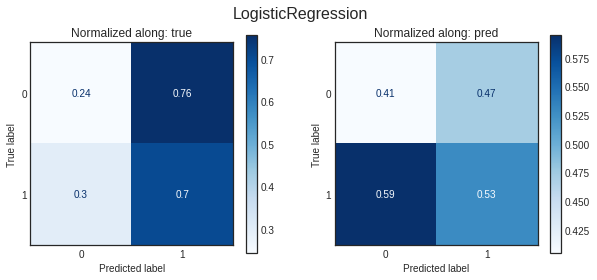

In [179]:

X_train_pol_sign = pd.concat([
    X_train_pol[["Lag2^2", "Lag1", "Lag1 Volume", "Lag1 Lag5", "Lag1^2", "Lag5"]] 
])
X_test_pol_sign = X_test_pol[["Lag2^2", "Lag1", "Lag1 Volume", "Lag1 Lag5", "Lag1^2", "Lag5"]] 
loggit = LogisticRegression().fit(X_train_pol_sign, y_train)
plot_cm(loggit, X_test_pol_sign, y_test, title=loggit.__class__.__name__)

print(
    loggit.__class__.__name__,'\n', 
    classification_report(y_test, loggit.predict(X_test_pol_sign))
)

LogisticRegression 
               precision    recall  f1-score   support

           0       0.43      0.67      0.52       131
           1       0.48      0.25      0.33       158

    accuracy                           0.44       289
   macro avg       0.45      0.46      0.43       289
weighted avg       0.46      0.44      0.42       289



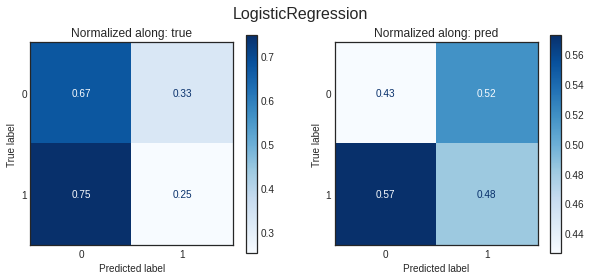

In [195]:
X_train_ext = pd.concat([
    X_train_pol[["Lag2^2", "Lag1 Volume", "Lag1 Lag5", "Lag1^2"]],
    X_train,
], axis=1)
X_test_ext = pd.concat([
    X_test_pol[["Lag2^2", "Lag1 Volume", "Lag1 Lag5", "Lag1^2"]],
    X_test,
    
], axis=1)

loggit = LogisticRegression().fit(X_train_ext, y_train)
plot_cm(loggit, X_test_ext, y_test, title=loggit.__class__.__name__)

print(
    loggit.__class__.__name__,'\n', 
    classification_report(y_test, loggit.predict(X_test_ext))
)

In [155]:
lda_clf, qda_clf, knn_clf, nb_clf, logit_cls = classifiers = [
    LogisticRegression().fit(X_train_pol, y_train),
    LDA().fit(X_train_pol, y_train), 
    QDA().fit(X_train_pol, y_train), 
    KNN(1).fit(X_train_pol, y_train), 
    GaussianNB().fit(X_train_pol, y_train)
]

LogisticRegression 
               precision    recall  f1-score   support

           0       0.50      0.01      0.02       131
           1       0.55      0.99      0.71       158

    accuracy                           0.55       289
   macro avg       0.52      0.50      0.36       289
weighted avg       0.53      0.55      0.39       289

LinearDiscriminantAnalysis 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       131
           1       0.55      0.99      0.70       158

    accuracy                           0.54       289
   macro avg       0.27      0.50      0.35       289
weighted avg       0.30      0.54      0.38       289

QuadraticDiscriminantAnalysis 
               precision    recall  f1-score   support

           0       0.50      0.02      0.03       131
           1       0.55      0.99      0.70       158

    accuracy                           0.55       289
   macro avg       0.52      0.50      0.37   

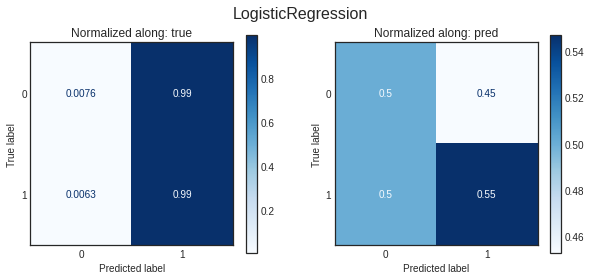

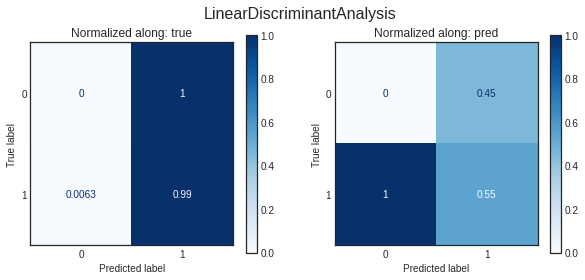

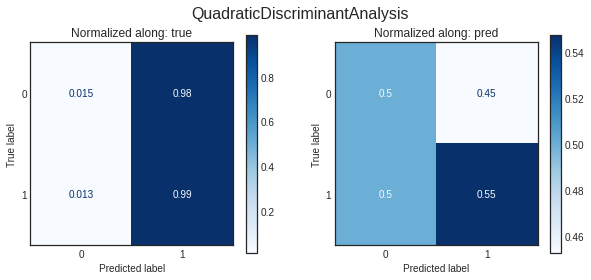

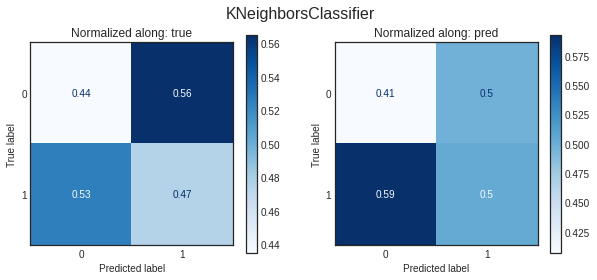

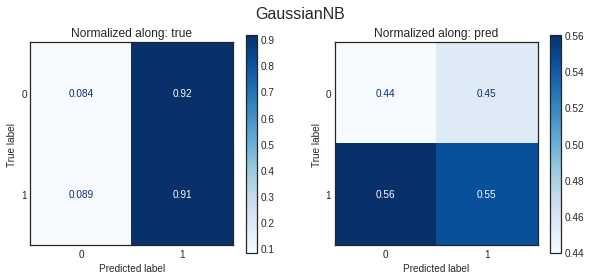

In [156]:
for clf in classifiers:
    plot_cm(clf, X_test_pol, y_test, title=clf.__class__.__name__)
    print(
        clf.__class__.__name__,'\n', 
        classification_report(y_test, clf.predict(X_test_pol))
    )